# Case Study 3

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers 
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - ...
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




In [1]:
import csv
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',')  
y = np.loadtxt('labels.csv', delimiter=',')

with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

num_subjects = 18
samples_per_subject = 10

num_subjects = 18
samples_per_subject = 10
X_reshaped = X.reshape((num_subjects * samples_per_subject, -1))
groups = np.repeat(np.arange(num_subjects), samples_per_subject)

print("X shape:", X_reshaped.shape)
print("y shape:", y.shape)
print("Number of features:", len(feature_names))


X shape: (180, 432)
y shape: (180,)
Number of features: 432


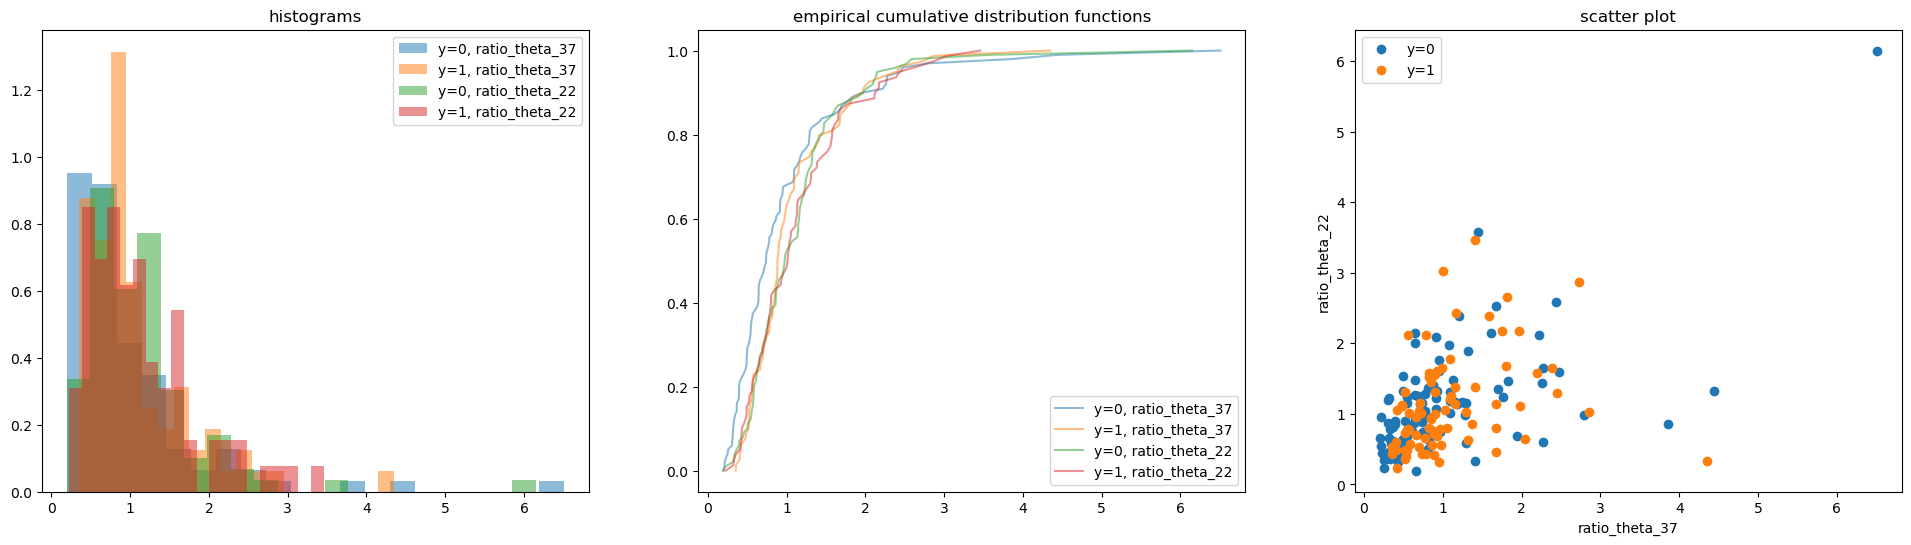

In [3]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9    # that's alpha_eye_close, beta_eye_close, theta_eye_close, and those eyes open*3, and ratio*3, summary is 9, each one lists 48 columns 
num_electrodes = 48 

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
f0, f1 = np.random.randint(0, num_features, size=2)
e = np.random.randint(0, num_electrodes)
i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
f = np.random.randint(0, num_features)
e0, e1 = np.random.randint(0, num_electrodes, size=2)
i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [4]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel, f_classif
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score




In [5]:
# data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Feature selection - Filtering method
selector_filter = SelectKBest(score_func=f_classif, k=10)
X_filtered = selector_filter.fit_transform(X_scaled, y)
print("Number of features after filter method:", X_filtered.shape[1])

# Feature selection - Wrapper method
classifier_wrapper = SVC(kernel="linear")
selector_wrapper = RFE(classifier_wrapper, n_features_to_select=10)
X_wrapped = selector_wrapper.fit_transform(X_scaled, y)
print("Number of features after wrapper method:", X_wrapped.shape[1])

# Feature selection - Embedded method (L1 regularization)
classifier_embedded = LinearSVC(penalty="l1", dual=False, max_iter=5000)
selector_embedded = SelectFromModel(classifier_embedded, max_features=10)  
X_embedded = selector_embedded.fit_transform(X_scaled, y)
print("Number of features after embedded method:", X_embedded.shape[1])

Number of features after filter method: 10
Number of features after wrapper method: 10
Number of features after embedded method: 10


Selected Feature Indices (Filter Method): [ 25 336 338 340 357 365 370 371 373 383]


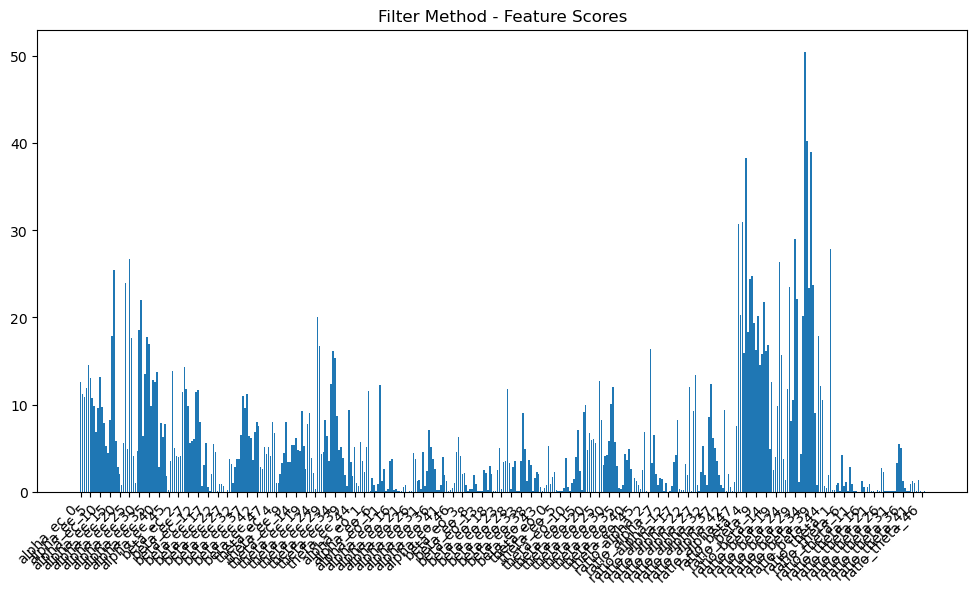

Selected Feature Indices (Wrapper Method): [ 59  74 121 147 149 175 208 218 354 383]


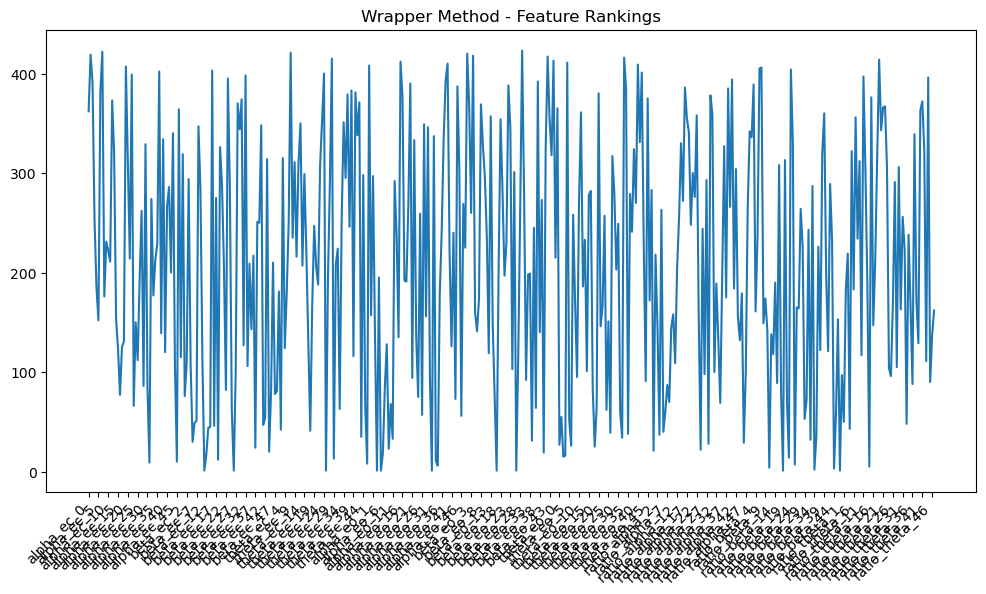

Selected Feature Indices (Embedded Method): [ 59 142 147 149 175 208 218 354 380 383]


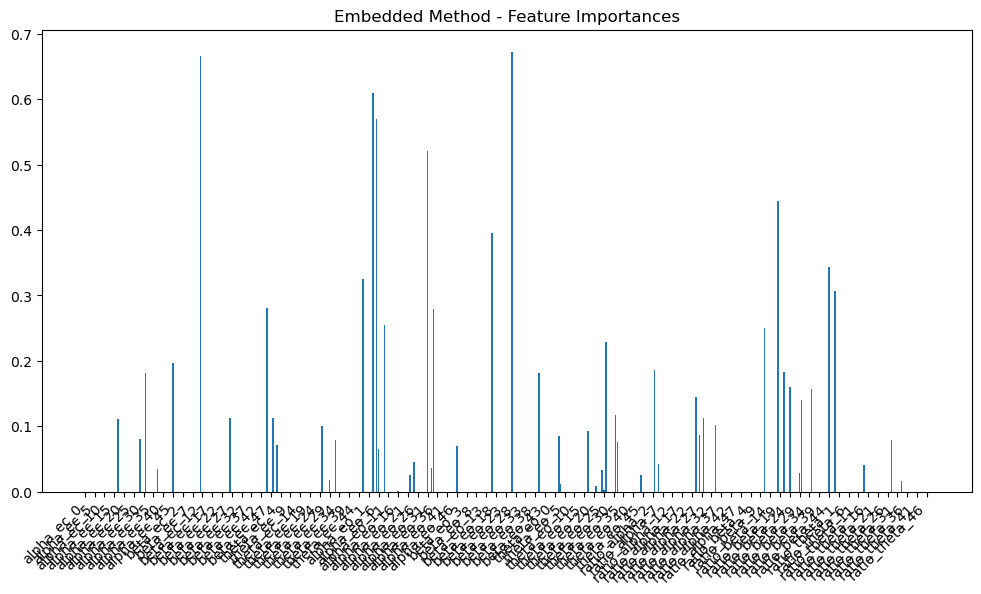

In [6]:
selected_features_filter = np.where(selector_filter.get_support())[0]
print("Selected Feature Indices (Filter Method):", selected_features_filter)

plt.figure(figsize=(12, 6))

# Filter Method - Feature Scores
scores = selector_filter.scores_
plt.bar(range(len(scores)), scores)
plt.xticks(np.arange(0, len(scores), step=5), feature_names[::5], rotation=45, ha="right")
plt.title("Filter Method - Feature Scores")
plt.show()

selected_features_wrapper = np.where(selector_wrapper.support_)[0]
print("Selected Feature Indices (Wrapper Method):", selected_features_wrapper)

plt.figure(figsize=(12, 6))

# Wrapper Method - Feature Rankings
ranking = selector_wrapper.ranking_
plt.plot(range(len(ranking)), ranking)
plt.xticks(np.arange(0, len(ranking), step=5), feature_names[::5], rotation=45, ha="right")
plt.title("Wrapper Method - Feature Rankings")
plt.show()

selected_features_embedded = np.where(selector_embedded.get_support())[0]
print("Selected Feature Indices (Embedded Method):", selected_features_embedded)

plt.figure(figsize=(12, 6))

# Embedded Method - Feature Importances
importances = np.abs(selector_embedded.estimator_.coef_.ravel())
plt.bar(range(len(importances)), importances)
plt.xticks(np.arange(0, len(importances), step=5), feature_names[::5], rotation=45, ha="right")
plt.title("Embedded Method - Feature Importances")
plt.show()



In [7]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel
from sklearn.compose import ColumnTransformer
import numpy as np

# Using Leave-One-Group-Out Cross-Validation
loo = LeaveOneGroupOut()
scaler = StandardScaler()

# Obtain Feature Selection Results
selected_features = {
    'filtered': np.where(selector_filter.get_support())[0],
    'wrapped': np.where(selector_wrapper.get_support())[0],
    'embedded': np.where(selector_embedded.get_support())[0]
}

# Define Feature Selector
feature_selector = ColumnTransformer(
    transformers=[('filtered', selector_filter, selected_features['filtered']),
                  ('wrapped', selector_wrapper, selected_features['wrapped']),
                  ('embedded', selector_embedded, selected_features['embedded'])]
)

# Build SVM Pipeline
svm_pipeline = Pipeline([
    ('scaler', scaler),
    ('features', feature_selector),
    ('classifier', SVC(probability=True))
])

# Define SVM Parameter Grid
param_grid_svm = {
    'features__filtered__k': [len(selected_features['filtered']), len(selected_features['embedded']), len(selected_features['wrapped'])],
    'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Perform Grid Search for Hyperparameter Optimization
grid_search_svm = GridSearchCV(
    svm_pipeline, param_grid_svm, cv=loo.split(X_scaled, y, groups=groups),
    scoring='accuracy', error_score='raise'
)
grid_search_svm.fit(X_scaled, y)

print("Best Parameters (SVM):", grid_search_svm.best_params_)

# Train SVM Model with Best Parameters
best_svm_classifier = grid_search_svm.best_estimator_
best_svm_classifier.fit(X_scaled, y)

Best Parameters (SVM): {'classifier__C': 10, 'classifier__kernel': 'rbf', 'features__filtered__k': 10}


Pipeline(steps=[('scaler', StandardScaler()),
                ('features',
                 ColumnTransformer(transformers=[('filtered', SelectKBest(),
                                                  array([ 25, 336, 338, 340, 357, 365, 370, 371, 373, 383], dtype=int64)),
                                                 ('wrapped',
                                                  RFE(estimator=SVC(kernel='linear'),
                                                      n_features_to_select=10),
                                                  array([ 59,  74, 121, 147, 149, 175, 208, 218, 354, 383], dtype=int64)),
                                                 ('embedded',
                                                  SelectFromModel(estimator=LinearSVC(dual=False,
                                                                                      max_iter=5000,
                                                                                      penalty='l1'),
                                                                  max_features=10),
                                                  array([ 59, 142, 147, 149, 175, 208, 218, 354, 380, 383], dtype=int64))])),
                ('classifier', SVC(C=10, probability=True))])

In [8]:
knn_pipeline = Pipeline([
    ('scaler', scaler),
    ('features', feature_selector),  # Use the feature_selector defined earlier
    ('classifier', KNeighborsClassifier())
])

# Define KNN Parameter Grid
param_grid_knn = {
    'features__filtered__k': [len(selected_features['filtered']), len(selected_features['embedded']), len(selected_features['wrapped'])],
    'classifier__n_neighbors': [3, 5, 7, 9,11,13], 'classifier__weights': ['uniform', 'distance']
}

# Perform GridSearchCV for Hyperparameter Optimization with KNN
grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=loo.split(X_scaled, y, groups=groups), scoring='accuracy')
grid_search_knn.fit(X_scaled, y)

print("Best Parameters (KNN):", grid_search_knn.best_params_)

# Train KNN Model with Best Parameters
best_knn_classifier = grid_search_knn.best_estimator_
best_knn_classifier.fit(X_scaled, y)

# The later models are generally similar, no need for too many comments

Best Parameters (KNN): {'classifier__n_neighbors': 11, 'classifier__weights': 'uniform', 'features__filtered__k': 10}


Pipeline(steps=[('scaler', StandardScaler()),
                ('features',
                 ColumnTransformer(transformers=[('filtered', SelectKBest(),
                                                  array([ 25, 336, 338, 340, 357, 365, 370, 371, 373, 383], dtype=int64)),
                                                 ('wrapped',
                                                  RFE(estimator=SVC(kernel='linear'),
                                                      n_features_to_select=10),
                                                  array([ 59,  74, 121, 147, 149, 175, 208, 218, 354, 383], dtype=int64)),
                                                 ('embedded',
                                                  SelectFromModel(estimator=LinearSVC(dual=False,
                                                                                      max_iter=5000,
                                                                                      penalty='l1'),
                                                                  max_features=10),
                                                  array([ 59, 142, 147, 149, 175, 208, 218, 354, 380, 383], dtype=int64))])),
                ('classifier', KNeighborsClassifier(n_neighbors=11))])

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

param_grid_rf = {
    'features__filtered__k': [len(selected_features['filtered']), len(selected_features['embedded']), len(selected_features['wrapped'])],
    'classifier__n_estimators': [50, 100, 200],  # Adjusting the number of trees.
    'classifier__max_depth': [5,10,15],  # Adjusting the maximum depth of the trees.
}

rf_pipeline = Pipeline([
    ('scaler', scaler),
    ('features', feature_selector),
    ('classifier', rf_classifier)
])

grid_search_rf = GridSearchCV(
    rf_pipeline, param_grid_rf, cv=loo.split(X_scaled, y, groups=groups),
    scoring='accuracy', error_score='raise'
)
grid_search_rf.fit(X_scaled, y)

print("Best Parameters (Random Forest):", grid_search_rf.best_params_)

best_rf_classifier = grid_search_rf.best_estimator_
best_rf_classifier.fit(X_scaled, y)


Best Parameters (Random Forest): {'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'features__filtered__k': 10}


Pipeline(steps=[('scaler', StandardScaler()),
                ('features',
                 ColumnTransformer(transformers=[('filtered', SelectKBest(),
                                                  array([ 25, 336, 338, 340, 357, 365, 370, 371, 373, 383], dtype=int64)),
                                                 ('wrapped',
                                                  RFE(estimator=SVC(kernel='linear'),
                                                      n_features_to_select=10),
                                                  array([ 59,  74, 121, 147, 149, 175, 208, 218, 354, 383], dtype=int64)),
                                                 ('embedded',
                                                  SelectFromModel(estimator=LinearSVC(dual=False,
                                                                                      max_iter=5000,
                                                                                      penalty='l1'),
                                                                  max_features=10),
                                                  array([ 59, 142, 147, 149, 175, 208, 218, 354, 380, 383], dtype=int64))])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

In [10]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_pipeline = Pipeline([
    ('scaler', scaler),
    ('features', feature_selector),
    ('classifier', nb_classifier)
])

# Define Naive Bayes Parameter Grid
param_grid_nb = {'features__filtered__k': [len(selected_features['filtered']), len(selected_features['embedded']), len(selected_features['wrapped'])],
    'classifier__priors': [None]}

grid_search_nb = GridSearchCV(
    nb_pipeline, param_grid_nb, cv=loo.split(X_scaled, y, groups=groups),
    scoring='accuracy', error_score='raise'
)
grid_search_nb.fit(X_scaled, y)

print("Best Parameters (Naive Bayes):", grid_search_nb.best_params_)

best_nb_classifier = grid_search_nb.best_estimator_
best_nb_classifier.fit(X_scaled,y)


from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression()
lr_pipeline = Pipeline([
    ('scaler', scaler),
    ('features', feature_selector),
    ('classifier', lr_classifier)
])

# Define Logistic Regression Parameter Grid
param_grid_lr = {'features__filtered__k': [len(selected_features['filtered']), len(selected_features['embedded']), len(selected_features['wrapped'])],
    'classifier__C': [0.1, 1, 10], 'classifier__penalty': ['l2']}

grid_search_lr = GridSearchCV(
    lr_pipeline, param_grid_lr, cv=loo.split(X_scaled, y, groups=groups),
    scoring='accuracy', error_score='raise'
)
grid_search_lr.fit(X_scaled, y)

print("Best Parameters (Logistic Regression):", grid_search_lr.best_params_)

best_lr_classifier = grid_search_lr.best_estimator_
best_lr_classifier.fit(X_scaled, y)

Best Parameters (Naive Bayes): {'classifier__priors': None, 'features__filtered__k': 10}
Best Parameters (Logistic Regression): {'classifier__C': 1, 'classifier__penalty': 'l2', 'features__filtered__k': 10}


Pipeline(steps=[('scaler', StandardScaler()),
                ('features',
                 ColumnTransformer(transformers=[('filtered', SelectKBest(),
                                                  array([ 25, 336, 338, 340, 357, 365, 370, 371, 373, 383], dtype=int64)),
                                                 ('wrapped',
                                                  RFE(estimator=SVC(kernel='linear'),
                                                      n_features_to_select=10),
                                                  array([ 59,  74, 121, 147, 149, 175, 208, 218, 354, 383], dtype=int64)),
                                                 ('embedded',
                                                  SelectFromModel(estimator=LinearSVC(dual=False,
                                                                                      max_iter=5000,
                                                                                      penalty='l1'),
                                                                  max_features=10),
                                                  array([ 59, 142, 147, 149, 175, 208, 218, 354, 380, 383], dtype=int64))])),
                ('classifier', LogisticRegression(C=1))])

In [11]:
# SVM - Gaussian Kernel 
svm_gaussian_classifier = SVC(kernel='rbf',probability=True)

param_grid_svm_gaussian = {
    'features__filtered__k': [len(selected_features['filtered']), len(selected_features['embedded']), len(selected_features['wrapped'])],
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [0.1, 1, 10]
}

grid_search_svm_gaussian = GridSearchCV(
    svm_pipeline, param_grid_svm_gaussian, cv=loo.split(X_scaled, y, groups=groups),
    scoring='accuracy', error_score='raise'
)
grid_search_svm_gaussian.fit(X_scaled, y)

print("Best Parameters (SVM Gaussian):", grid_search_svm_gaussian.best_params_)

best_svm_gaussian_classifier = grid_search_svm_gaussian.best_estimator_
best_svm_gaussian_classifier.fit(X_scaled, y)


# SVM - Polynomial Kernel 
svm_poly_classifier = SVC(kernel='poly',probability=True)

param_grid_svm_poly = {
    'features__filtered__k': [len(selected_features['filtered']), len(selected_features['embedded']), len(selected_features['wrapped'])],
    'classifier__C': [0.1, 1, 10],
    'classifier__degree': [2, 3, 4]
}

grid_search_svm_poly = GridSearchCV(
    svm_pipeline, param_grid_svm_poly, cv=loo.split(X_scaled, y, groups=groups),
    scoring='accuracy', error_score='raise'
)
grid_search_svm_poly.fit(X_scaled, y)

print("Best Parameters (SVM Polynomial):", grid_search_svm_poly.best_params_)

best_svm_poly_classifier = grid_search_svm_poly.best_estimator_
best_svm_poly_classifier.fit(X_scaled, y)



Best Parameters (SVM Gaussian): {'classifier__C': 10, 'classifier__gamma': 0.1, 'features__filtered__k': 10}
Best Parameters (SVM Polynomial): {'classifier__C': 10, 'classifier__degree': 2, 'features__filtered__k': 10}


Pipeline(steps=[('scaler', StandardScaler()),
                ('features',
                 ColumnTransformer(transformers=[('filtered', SelectKBest(),
                                                  array([ 25, 336, 338, 340, 357, 365, 370, 371, 373, 383], dtype=int64)),
                                                 ('wrapped',
                                                  RFE(estimator=SVC(kernel='linear'),
                                                      n_features_to_select=10),
                                                  array([ 59,  74, 121, 147, 149, 175, 208, 218, 354, 383], dtype=int64)),
                                                 ('embedded',
                                                  SelectFromModel(estimator=LinearSVC(dual=False,
                                                                                      max_iter=5000,
                                                                                      penalty='l1'),
                                                                  max_features=10),
                                                  array([ 59, 142, 147, 149, 175, 208, 218, 354, 380, 383], dtype=int64))])),
                ('classifier', SVC(C=10, degree=2, probability=True))])

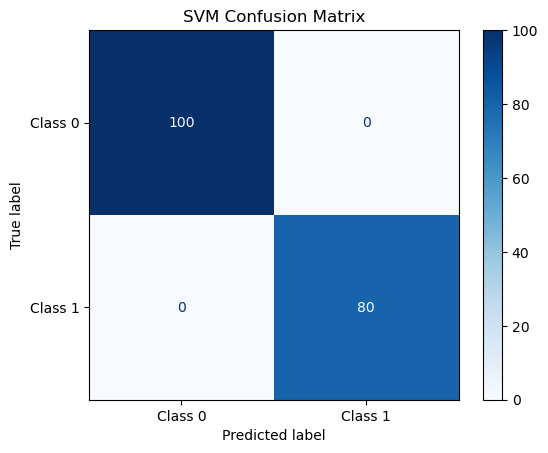

SVM Accuracy: 1.0
SVM Precision: 1.0
SVM Recall: 1.0
SVM F1 Score: 1.0


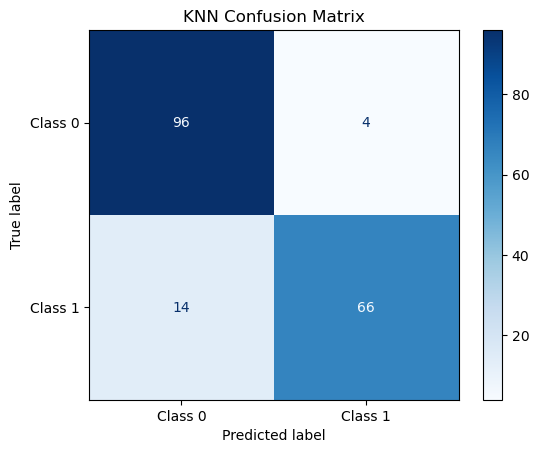

KNN Accuracy: 0.9
KNN Precision: 0.9428571428571428
KNN Recall: 0.825
KNN F1 Score: 0.88


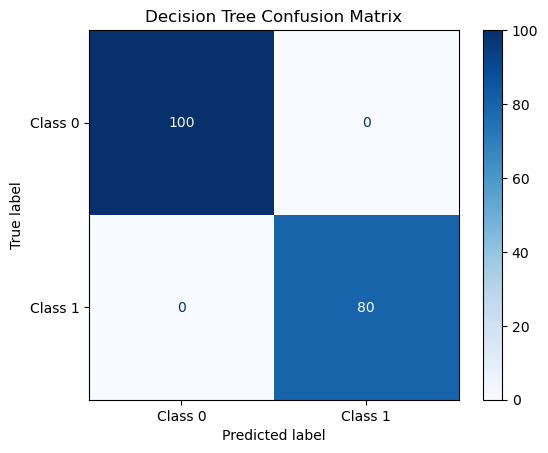

Decision Tree Accuracy: 1.0
Decision Tree Precision: 1.0
Decision Tree Recall: 1.0
Decision Tree F1 Score: 1.0


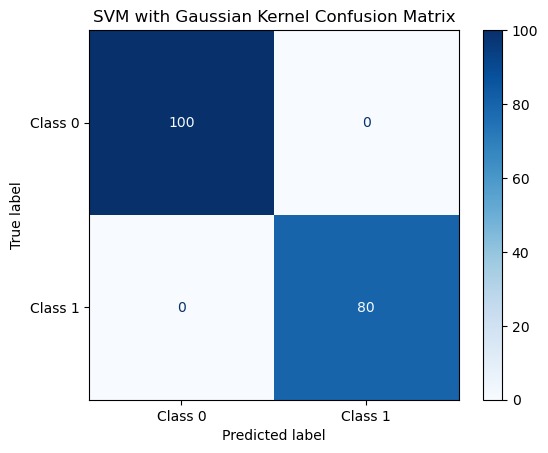

SVM with Gaussian Kernel Accuracy: 1.0
SVM with Gaussian Kernel Precision: 1.0
SVM with Gaussian Kernel Recall: 1.0
SVM with Gaussian Kernel F1 Score: 1.0


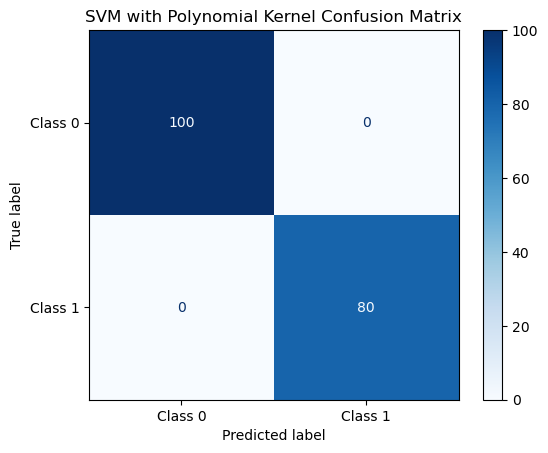

SVM with Polynomial Kernel Accuracy: 1.0
SVM with Polynomial Kernel Precision: 1.0
SVM with Polynomial Kernel Recall: 1.0
SVM with Polynomial Kernel F1 Score: 1.0


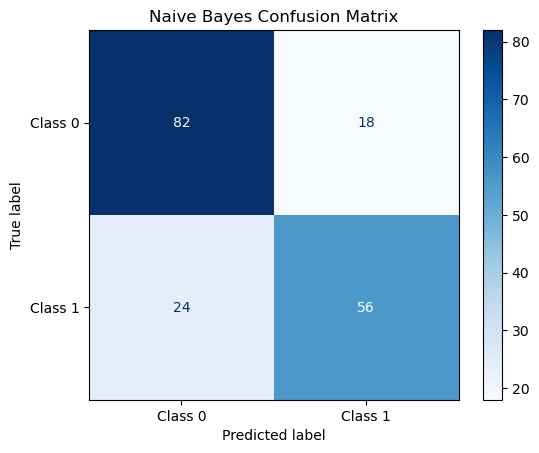

Naive Bayes Accuracy: 0.7666666666666667
Naive Bayes Precision: 0.7567567567567568
Naive Bayes Recall: 0.7
Naive Bayes F1 Score: 0.7272727272727273


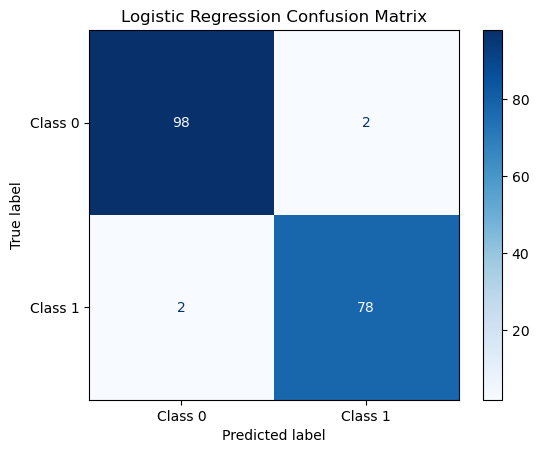

Logistic Regression Accuracy: 0.9777777777777777
Logistic Regression Precision: 0.975
Logistic Regression Recall: 0.975
Logistic Regression F1 Score: 0.975


In [12]:
# SVM Model Performance Evaluation
svm_predictions = best_svm_classifier.predict(X_scaled)
# Confusion Matrix
conf_matrix_svm = confusion_matrix(y, svm_predictions)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=["Class 0", "Class 1"])
disp_svm.plot(cmap='Blues', values_format='d')
plt.title("SVM Confusion Matrix")
plt.show()
# Accuracy
svm_accuracy = accuracy_score(y, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
# Precision
svm_precision = precision_score(y, svm_predictions)
print("SVM Precision:", svm_precision)
# Recall
svm_recall = recall_score(y, svm_predictions)
print("SVM Recall:", svm_recall)
# F1 score
svm_f1 = f1_score(y, svm_predictions)
print("SVM F1 Score:", svm_f1)

# KNN Model Performance Evaluation
knn_predictions = best_knn_classifier.predict(X_scaled)
conf_matrix_knn = confusion_matrix(y, knn_predictions)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn, display_labels=["Class 0", "Class 1"])
disp_knn.plot(cmap='Blues', values_format='d')
plt.title("KNN Confusion Matrix")
plt.show()

knn_accuracy = accuracy_score(y, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

knn_precision = precision_score(y, knn_predictions)
print("KNN Precision:", knn_precision)

knn_recall = recall_score(y, knn_predictions)
print("KNN Recall:", knn_recall)

knn_f1 = f1_score(y, knn_predictions)
print("KNN F1 Score:", knn_f1)

# Decision Tree Model Performance Evaluation
dt_predictions = best_rf_classifier.predict(X_scaled)
conf_matrix_dt = confusion_matrix(y, dt_predictions)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt, display_labels=["Class 0", "Class 1"])
disp_dt.plot(cmap='Blues', values_format='d')
plt.title("Decision Tree Confusion Matrix")
plt.show()

dt_accuracy = accuracy_score(y, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)

dt_precision = precision_score(y, dt_predictions)
print("Decision Tree Precision:", dt_precision)

dt_recall = recall_score(y, dt_predictions)
print("Decision Tree Recall:", dt_recall)

dt_f1 = f1_score(y, dt_predictions)
print("Decision Tree F1 Score:", dt_f1)

# Gaussian Kernel SVM Model Performance Evaluation
svm_gaussian_predictions = best_svm_gaussian_classifier.predict(X_scaled)
conf_matrix_svm_rbf = confusion_matrix(y, svm_gaussian_predictions)
disp_svm_rbf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm_rbf, display_labels=["Class 0", "Class 1"])
disp_svm_rbf.plot(cmap='Blues', values_format='d')
plt.title("SVM with Gaussian Kernel Confusion Matrix")
plt.show()

svm_gaussian_accuracy = accuracy_score(y, svm_gaussian_predictions)
print("SVM with Gaussian Kernel Accuracy:", svm_gaussian_accuracy)

svm_gaussian_precision = precision_score(y, svm_gaussian_predictions)
print("SVM with Gaussian Kernel Precision:", svm_gaussian_precision)

svm_gaussian_recall = recall_score(y, svm_gaussian_predictions)
print("SVM with Gaussian Kernel Recall:", svm_gaussian_recall)

svm_gaussian_f1 = f1_score(y, svm_gaussian_predictions)
print("SVM with Gaussian Kernel F1 Score:", svm_gaussian_f1)

# Gaussian Kernel SVM Model Performance Evaluation
svm_poly_predictions = best_svm_poly_classifier.predict(X_scaled)
conf_matrix_svm_poly = confusion_matrix(y, svm_poly_predictions)
disp_svm_poly = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm_poly, display_labels=["Class 0", "Class 1"])
disp_svm_poly.plot(cmap='Blues', values_format='d')
plt.title("SVM with Polynomial Kernel Confusion Matrix")
plt.show()

svm_poly_accuracy = accuracy_score(y, svm_poly_predictions)
print("SVM with Polynomial Kernel Accuracy:", svm_poly_accuracy)

svm_poly_precision = precision_score(y, svm_poly_predictions)
print("SVM with Polynomial Kernel Precision:", svm_poly_precision)

svm_poly_recall = recall_score(y, svm_poly_predictions)
print("SVM with Polynomial Kernel Recall:", svm_poly_recall)

svm_poly_f1 = f1_score(y, svm_poly_predictions)
print("SVM with Polynomial Kernel F1 Score:", svm_poly_f1)

# Naive Bayes Model Performance Evaluation
nb_predictions = best_nb_classifier.predict(X_scaled)
conf_matrix_nb = confusion_matrix(y, nb_predictions)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nb, display_labels=["Class 0", "Class 1"])
disp_nb.plot(cmap='Blues', values_format='d')
plt.title("Naive Bayes Confusion Matrix")
plt.show()

nb_accuracy = accuracy_score(y, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

nb_precision = precision_score(y, nb_predictions)
print("Naive Bayes Precision:", nb_precision)

nb_recall = recall_score(y, nb_predictions)
print("Naive Bayes Recall:", nb_recall)

nb_f1 = f1_score(y, nb_predictions)
print("Naive Bayes F1 Score:", nb_f1)

# Logistic Regression Model Performance Evaluation
lr_predictions = best_lr_classifier.predict(X_scaled)
conf_matrix_lr = confusion_matrix(y, lr_predictions)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr, display_labels=["Class 0", "Class 1"])
disp_lr.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

lr_accuracy = accuracy_score(y, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)

lr_precision = precision_score(y, lr_predictions)
print("Logistic Regression Precision:", lr_precision)

lr_recall = recall_score(y, lr_predictions)
print("Logistic Regression Recall:", lr_recall)

lr_f1 = f1_score(y, lr_predictions)
print("Logistic Regression F1 Score:", lr_f1)

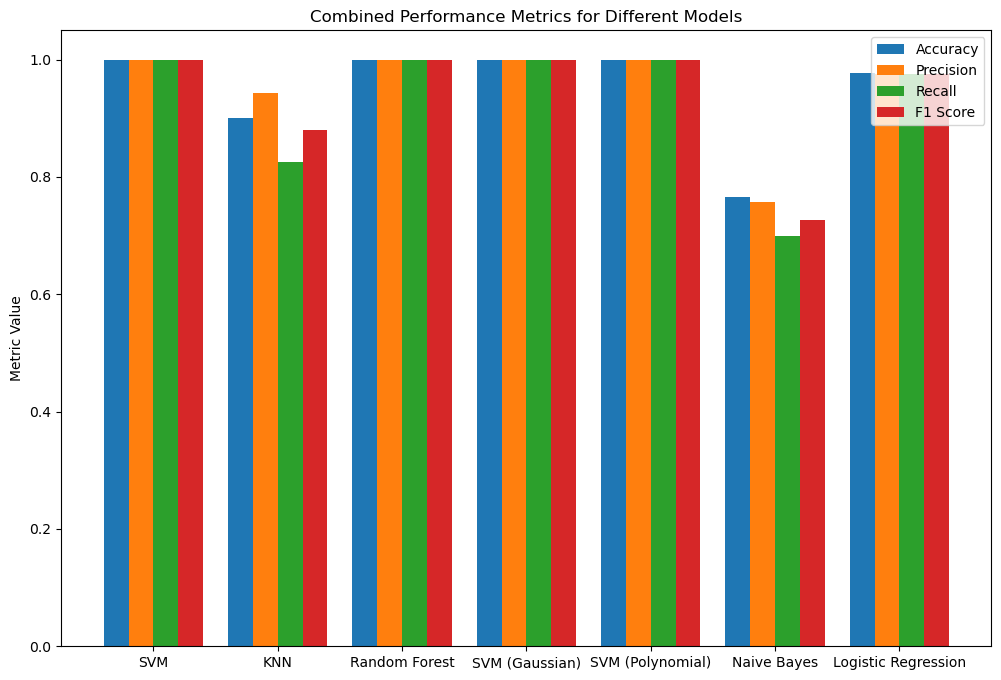

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate performance metrics
def calculate_metrics(predictions):
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)
    return accuracy, precision, recall, f1

# Get metrics for each model
svm_metrics = calculate_metrics(svm_predictions)
knn_metrics = calculate_metrics(knn_predictions)
rf_metrics = calculate_metrics(dt_predictions)
svm_gaussian_metrics = calculate_metrics(svm_gaussian_predictions)
svm_poly_metrics = calculate_metrics(svm_poly_predictions)
nb_metrics = calculate_metrics(nb_predictions)
lr_metrics = calculate_metrics(lr_predictions)

# Combine metrics for all models
models = ['SVM', 'KNN', 'Random Forest', 'SVM (Gaussian)', 'SVM (Polynomial)', 'Naive Bayes', 'Logistic Regression']
accuracy_values = [svm_metrics[0], knn_metrics[0], rf_metrics[0], svm_gaussian_metrics[0], svm_poly_metrics[0], nb_metrics[0], lr_metrics[0]]
precision_values = [svm_metrics[1], knn_metrics[1], rf_metrics[1], svm_gaussian_metrics[1], svm_poly_metrics[1], nb_metrics[1], lr_metrics[1]]
recall_values = [svm_metrics[2], knn_metrics[2], rf_metrics[2], svm_gaussian_metrics[2], svm_poly_metrics[2], nb_metrics[2], lr_metrics[2]]
f1_values = [svm_metrics[3], knn_metrics[3], rf_metrics[3], svm_gaussian_metrics[3], svm_poly_metrics[3], nb_metrics[3], lr_metrics[3]]

# Plot combined metrics
width = 0.2  # the width of the bars
ind = np.arange(len(models))

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(ind - 1.5 * width, accuracy_values, width, label='Accuracy')
ax.bar(ind - 0.5 * width, precision_values, width, label='Precision')
ax.bar(ind + 0.5 * width, recall_values, width, label='Recall')
ax.bar(ind + 1.5 * width, f1_values, width, label='F1 Score')

ax.set_xticks(ind)
ax.set_xticklabels(models)
ax.set_ylabel('Metric Value')
ax.set_title('Combined Performance Metrics for Different Models')
ax.legend()

plt.show()


In [14]:
# Leave-One-Out Cross-Validation
# SVM 
svm_scores = []
for train_index, test_index in loo.split(X_scaled, y, groups=groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_svm_classifier.fit(X_train, y_train)
    y_pred_svm = best_svm_classifier.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    svm_scores.append(accuracy_svm)

# KNN 
knn_scores = []
for train_index, test_index in loo.split(X_scaled, y, groups=groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_knn_classifier.fit(X_train, y_train)
    y_pred_knn = best_knn_classifier.predict(X_test)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    knn_scores.append(accuracy_knn)

# Random Forest
rf_scores = []
for train_index, test_index in loo.split(X_scaled, y, groups=groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_rf_classifier.fit(X_train, y_train)
    y_pred_rf = best_rf_classifier.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    rf_scores.append(accuracy_rf)

# SVM - Gaussian Kernel
svm_gaussian_scores = []
for train_index, test_index in loo.split(X_scaled, y, groups=groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_svm_gaussian_classifier.fit(X_train, y_train)
    y_pred_svm_gaussian = best_svm_gaussian_classifier.predict(X_test)
    accuracy_svm_gaussian = accuracy_score(y_test, y_pred_svm_gaussian)
    svm_gaussian_scores.append(accuracy_svm_gaussian)

# SVM - Polynomial Kernel
svm_poly_scores = []
for train_index, test_index in loo.split(X_scaled, y, groups=groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_svm_poly_classifier.fit(X_train, y_train)
    y_pred_svm_poly = best_svm_poly_classifier.predict(X_test)
    accuracy_svm_poly = accuracy_score(y_test, y_pred_svm_poly)
    svm_poly_scores.append(accuracy_svm_poly)

# Naive Bayes
nb_scores = []
for train_index, test_index in loo.split(X_scaled, y, groups=groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_nb_classifier.fit(X_train, y_train)
    y_pred_nb = best_nb_classifier.predict(X_test)
    accuracy_nb = accuracy_score(y_test, y_pred_nb)
    nb_scores.append(accuracy_nb)

# Logistic Regression
lr_scores = []
for train_index, test_index in loo.split(X_scaled, y, groups=groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_lr_classifier.fit(X_train, y_train)
    y_pred_lr = best_lr_classifier.predict(X_test)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    lr_scores.append(accuracy_lr)


print("Average Accuracy(SVM):", sum(svm_scores) / len(svm_scores))
print("Average Accuracy(KNN):", sum(knn_scores) / len(knn_scores))
print("Average Accuracy(RF):", sum(rf_scores) / len(rf_scores))
print("Average Accuracy(SVM-Gaussian):", sum(svm_gaussian_scores) / len(svm_gaussian_scores))
print("Average Accuracy(SVM-Polynomial):", sum(svm_poly_scores) / len(svm_poly_scores))
print("Average Accuracy(Naive Bayes):", sum(nb_scores) / len(nb_scores))
print("Average Accuracy(Logistic Regression):", sum(lr_scores) / len(lr_scores))

Average Accuracy(SVM): 0.9500000000000001
Average Accuracy(KNN): 0.8611111111111112
Average Accuracy(RF): 0.8444444444444446
Average Accuracy(SVM-Gaussian): 0.9111111111111112
Average Accuracy(SVM-Polynomial): 0.9500000000000001
Average Accuracy(Naive Bayes): 0.7555555555555556
Average Accuracy(Logistic Regression): 0.9333333333333336


In [15]:
y_pred_svm = best_svm_classifier.predict(X_scaled)
print("SVM Classification Report:\n", classification_report(y, y_pred_svm))

y_pred_knn = best_knn_classifier.predict(X_scaled)
print("KNN Classification Report:\n", classification_report(y, y_pred_knn))

y_pred_rf = best_rf_classifier.predict(X_scaled)
print("KNN Classification Report:\n", classification_report(y, y_pred_rf))

y_pred_svm_gaussian = best_svm_gaussian_classifier.predict(X_scaled)
print("SVM Gaussian Kernel Classification Report:\n", classification_report(y, y_pred_svm_gaussian))

y_pred_svm_polynomial = best_svm_poly_classifier.predict(X_scaled)
print("SVM Polynomial Kernel Classification Report:\n", classification_report(y, y_pred_svm_polynomial))

y_pred_nb = best_nb_classifier.predict(X_scaled)
print("Naive Bayes Classification Report:\n", classification_report(y, y_pred_nb))

y_pred_lr = best_lr_classifier.predict(X_scaled)
print("Logistic Regression Classification Report:\n", classification_report(y, y_pred_lr))


SVM Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00        80

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       100
         1.0       0.94      0.82      0.88        80

    accuracy                           0.90       180
   macro avg       0.91      0.89      0.90       180
weighted avg       0.90      0.90      0.90       180

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       100
         1.0       1.00      0.97      0.99        80

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99 

In [16]:
# Baseline Comparison
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SVM 
baseline_svm_classifier = SVC()
baseline_svm_classifier.fit(X_train_baseline, y_train_baseline)
y_pred_svm_baseline = baseline_svm_classifier.predict(X_test_baseline)
accuracy_svm_baseline = accuracy_score(y_test_baseline, y_pred_svm_baseline)
print("Baseline Accuracy (SVM):", accuracy_svm_baseline)

# KNN 
baseline_knn_classifier = KNeighborsClassifier()
baseline_knn_classifier.fit(X_train_baseline, y_train_baseline)
y_pred_knn_baseline = baseline_knn_classifier.predict(X_test_baseline)
accuracy_knn_baseline = accuracy_score(y_test_baseline, y_pred_knn_baseline)
print("Baseline Accuracy (KNN):", accuracy_knn_baseline)

# Random Forest
baseline_rf_classifier = RandomForestClassifier()
baseline_rf_classifier.fit(X_train_baseline, y_train_baseline)
y_pred_rf_baseline = baseline_rf_classifier.predict(X_test_baseline)
accuracy_rf_baseline = accuracy_score(y_test_baseline, y_pred_rf_baseline)
print("Baseline Accuracy (Random Forest):", accuracy_rf_baseline)

# SVM - Gaussian Kernel
baseline_svm_gaussian_classifier = SVC(kernel='rbf')
baseline_svm_gaussian_classifier.fit(X_train_baseline, y_train_baseline)
y_pred_svm_gaussian_baseline = baseline_svm_gaussian_classifier.predict(X_test_baseline)
accuracy_svm_gaussian_baseline = accuracy_score(y_test_baseline, y_pred_svm_gaussian_baseline)
print("Baseline Accuracy (SVM Gaussian):", accuracy_svm_gaussian_baseline)

# SVM - Polynomial Kernel
baseline_svm_poly_classifier = SVC(kernel='poly')
baseline_svm_poly_classifier.fit(X_train_baseline, y_train_baseline)
y_pred_svm_poly_baseline = baseline_svm_poly_classifier.predict(X_test_baseline)
accuracy_svm_poly_baseline = accuracy_score(y_test_baseline, y_pred_svm_poly_baseline)
print("Baseline Accuracy (SVM Polynomial):", accuracy_svm_poly_baseline)

# Naive Bayes
baseline_nb_classifier = GaussianNB()
baseline_nb_classifier.fit(X_train_baseline, y_train_baseline)
y_pred_nb_baseline = baseline_nb_classifier.predict(X_test_baseline)
accuracy_nb_baseline = accuracy_score(y_test_baseline, y_pred_nb_baseline)
print("Baseline Accuracy (Naive Bayes):", accuracy_nb_baseline)

# Logistic Regression
baseline_lr_classifier = LogisticRegression()
baseline_lr_classifier.fit(X_train_baseline, y_train_baseline)
y_pred_lr_baseline = baseline_lr_classifier.predict(X_test_baseline)
accuracy_lr_baseline = accuracy_score(y_test_baseline, y_pred_lr_baseline)
print("Baseline Accuracy (Logistic Regression):", accuracy_lr_baseline)



Baseline Accuracy (SVM): 0.8611111111111112
Baseline Accuracy (KNN): 0.8888888888888888
Baseline Accuracy (Random Forest): 0.7777777777777778
Baseline Accuracy (SVM Gaussian): 0.8611111111111112
Baseline Accuracy (SVM Polynomial): 0.6666666666666666
Baseline Accuracy (Naive Bayes): 0.6944444444444444
Baseline Accuracy (Logistic Regression): 0.9166666666666666


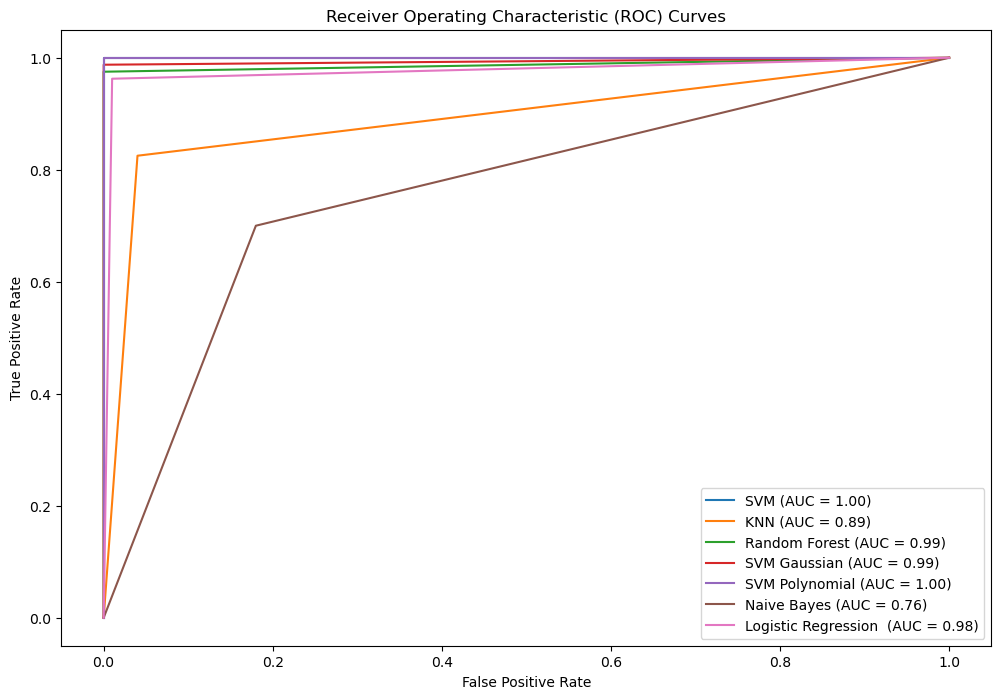

In [17]:
from sklearn.metrics import RocCurveDisplay
import scikitplot as skplt
import matplotlib.pyplot as plt

# Assuming X_scaled, y, and groups are defined
fig, ax = plt.subplots(figsize=(12, 8))

classifiers = [best_svm_classifier, best_knn_classifier, best_rf_classifier,
               best_svm_gaussian_classifier, best_svm_poly_classifier, best_nb_classifier, best_lr_classifier]
names = ['SVM','KNN','Random Forest','SVM Gaussian','SVM Polynomial','Naive Bayes','Logistic Regression ']

for i in range(0,len(names)):
    classifier = classifiers[i]
    # Assuming classifier has predict_proba method
    y_probas = classifier.predict(X_scaled)
    
    # Create RocCurveDisplay from predicted probabilities
    roc_display = RocCurveDisplay.from_predictions(y, y_probas, ax=ax, name=names[i])

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')

# Show the plot
plt.show()


Mean Squared Error (SVM): 0.0, RMSE: 0.0, MAE: 0.0
Mean Squared Error (KNN): 0.1, RMSE: 0.31622776601683794, MAE: 0.1
Mean Squared Error (Random Forest): 0.011111111111111112, RMSE: 0.10540925533894598, MAE: 0.011111111111111112
Mean Squared Error (SVM Gaussian): 0.005555555555555556, RMSE: 0.07453559924999299, MAE: 0.005555555555555556
Mean Squared Error (SVM Polynomial): 0.0, RMSE: 0.0, MAE: 0.0
Mean Squared Error (Naive Bayes): 0.23333333333333334, RMSE: 0.48304589153964794, MAE: 0.23333333333333334
Mean Squared Error (Logistic Regression): 0.022222222222222223, RMSE: 0.14907119849998599, MAE: 0.022222222222222223


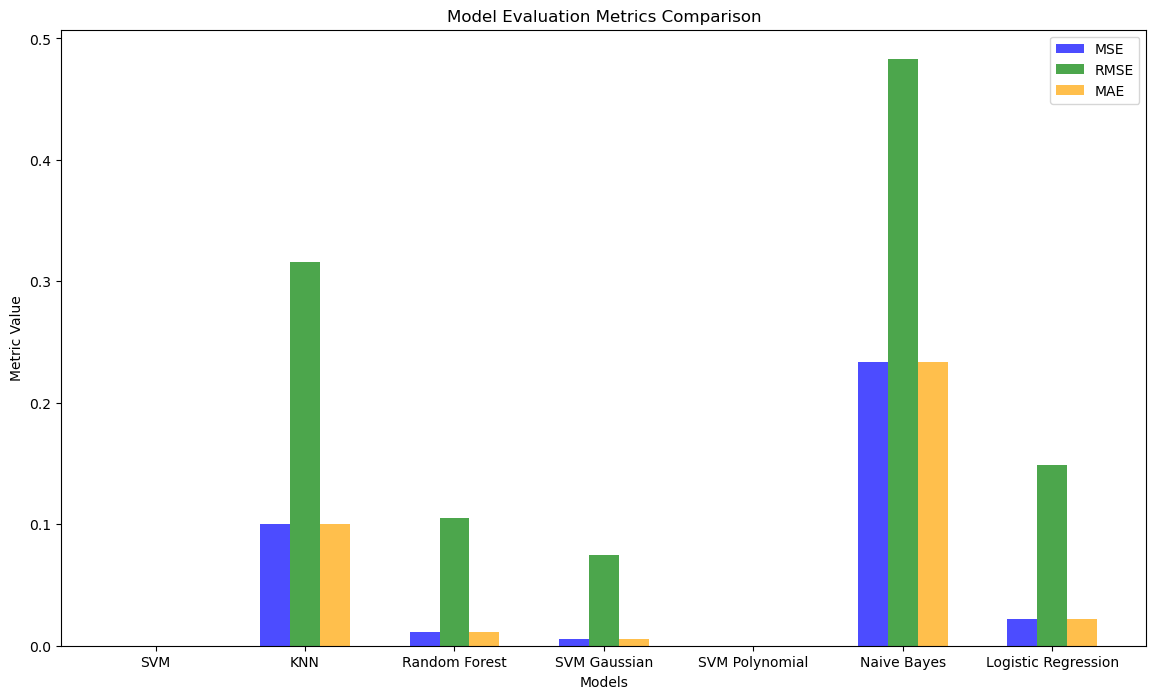

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions for each classifier
y_pred_svm = best_svm_classifier.predict(X_scaled)
y_pred_knn = best_knn_classifier.predict(X_scaled)
y_pred_rf = best_rf_classifier.predict(X_scaled)
y_pred_gaussian = best_svm_gaussian_classifier.predict(X_scaled)
y_pred_poly = best_svm_poly_classifier.predict(X_scaled)
y_pred_nb = best_nb_classifier.predict(X_scaled)
y_pred_lr = best_lr_classifier.predict(X_scaled)

# Calculate metrics for SVM
mse_svm = mean_squared_error(y, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
mae_svm = mean_absolute_error(y, y_pred_svm)

# Calculate metrics for KNN
mse_knn = mean_squared_error(y, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y, y_pred_knn)

# Calculate metrics for Random Forest
mse_rf = mean_squared_error(y, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y, y_pred_rf)

# Calculate metrics for SVM with Gaussian Kernel
mse_gaussian = mean_squared_error(y, y_pred_gaussian)
rmse_gaussian = np.sqrt(mse_gaussian)
mae_gaussian = mean_absolute_error(y, y_pred_gaussian)

# Calculate metrics for SVM with Polynomial Kernel
mse_poly = mean_squared_error(y, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
mae_poly = mean_absolute_error(y, y_pred_poly)

# Calculate metrics for Naive Bayes
mse_nb = mean_squared_error(y, y_pred_nb)
rmse_nb = np.sqrt(mse_nb)
mae_nb = mean_absolute_error(y, y_pred_nb)

# Calculate metrics for Logistic Regression
mse_lr = mean_squared_error(y, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y, y_pred_lr)

# Print or use the values as needed
print(f'Mean Squared Error (SVM): {mse_svm}, RMSE: {rmse_svm}, MAE: {mae_svm}')
print(f'Mean Squared Error (KNN): {mse_knn}, RMSE: {rmse_knn}, MAE: {mae_knn}')
print(f'Mean Squared Error (Random Forest): {mse_rf}, RMSE: {rmse_rf}, MAE: {mae_rf}')
print(f'Mean Squared Error (SVM Gaussian): {mse_gaussian}, RMSE: {rmse_gaussian}, MAE: {mae_gaussian}')
print(f'Mean Squared Error (SVM Polynomial): {mse_poly}, RMSE: {rmse_poly}, MAE: {mae_poly}')
print(f'Mean Squared Error (Naive Bayes): {mse_nb}, RMSE: {rmse_nb}, MAE: {mae_nb}')
print(f'Mean Squared Error (Logistic Regression): {mse_lr}, RMSE: {rmse_lr}, MAE: {mae_lr}')

# Define models and corresponding metrics
models = ['SVM', 'KNN', 'Random Forest', 'SVM Gaussian', 'SVM Polynomial', 'Naive Bayes', 'Logistic Regression']
mse_values = [mse_svm, mse_knn, mse_rf, mse_gaussian, mse_poly, mse_nb, mse_lr]
rmse_values = [rmse_svm, rmse_knn, rmse_rf, rmse_gaussian, rmse_poly, rmse_nb, rmse_lr]
mae_values = [mae_svm, mae_knn, mae_rf, mae_gaussian, mae_poly, mae_nb, mae_lr]

bar_width = 0.2  # Width of each bar
index = np.arange(len(models))  # Index for the models

# Plotting MSE, RMSE, MAE for each model
plt.figure(figsize=(14, 8))
plt.bar(index - bar_width, mse_values, width=bar_width, color='blue', alpha=0.7, label='MSE')
plt.bar(index, rmse_values, width=bar_width, color='green', alpha=0.7, label='RMSE')
plt.bar(index + bar_width, mae_values, width=bar_width, color='orange', alpha=0.7, label='MAE')

plt.title('Model Evaluation Metrics Comparison')
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.xticks(index, models)
plt.legend()
plt.show()
